In [2]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import pretrainedmodels
import torch
from pathlib import Path
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from learn import Learner
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from datetime import datetime

from dataset import MontgomeryDataset
from transform import lung_segmentation_transfrom
from dataloader import LungSegmentationDataLoader
from recorder import LearningRecorder
from metrics import dice

In [4]:
bs = 2
sz = 128
PATH = Path('/mnt/data/xray-thesis/data/MontgomerySet')
MODELS = 'models'

model_name = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
print(model_name)

net = pretrainedmodels.__dict__['resnet34']()
backbone = nn.Sequential(*list(net.children())[:-2])

20190122-112633


In [5]:
tfms = lung_segmentation_transfrom(net, sz)
dataloader = LungSegmentationDataLoader(tfms, bs)

class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

denorm = transforms.Compose([
    Denormalize(net.mean, net.std),
    transforms.ToPILImage()
])

to_pil = transforms.ToPILImage()

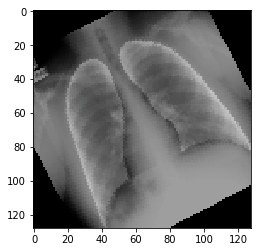

In [6]:
image, target = dataloader.train.dataset[2]
image = denorm(image)
plt.imshow(image)
plt.imshow(to_pil(target), alpha=.3)

In [7]:
len(dataloader.train.dataset), len(dataloader.val.dataset)

(103, 35)

In [8]:
backbone

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [9]:
class SaveFeatures():
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def remove(self):
        self.hook.remove()

In [10]:
class UnetBlock(nn.Module):
    
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out // 2
        self.x_conv = nn.Conv2d(x_in, x_out, 1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
    
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p) 
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p, x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [11]:
class Unet34(nn.Module):
    
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.sfs = [SaveFeatures(backbone[i]) for i in [2, 4, 5, 6]]
        self.up1 = UnetBlock(512, 256, 256)
        self.up2 = UnetBlock(256, 128, 256)
        self.up3 = UnetBlock(256, 64, 256)
        self.up4 = UnetBlock(256, 64, 256)
        self.up5 = nn.ConvTranspose2d(256, 1, kernel_size=2, stride=2)
    
    def forward(self, x):
        # x: -1, 3, h, w
        x = F.relu(self.backbone(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [12]:
model = Unet34(backbone).cuda()
optimizer = optim.Adam(model.parameters())
# https://stats.stackexchange.com/questions/321460/dice-coefficient-loss-function-vs-cross-entropy
criterion = nn.BCEWithLogitsLoss()
recorder = LearningRecorder(PATH/MODELS, model_name)

In [13]:
learn = Learner(model, dataloader, criterion, recorder, PATH/MODELS, model_name)

In [15]:
learn.find_lr()

 73%|███████▎  | 38/52 [00:06<00:02,  5.49it/s]


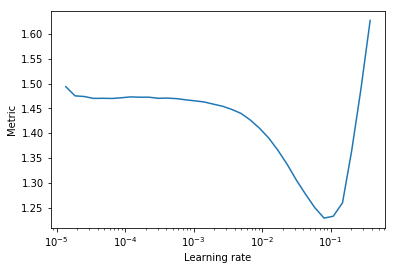

In [16]:
learn.sched.plot(0, 5)

In [15]:
lr = 1e-2
learn.fit(lr, 50, metrics=[dice])

Train:   0%|          | 0/52 [00:00<?, ?it/s]                     

epoch      trn_loss   val_loss   trn_dice   val_dice   
    0      0.182187   0.14273    0.874409   0.897551  


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    1      0.157629   0.099359   0.899121   0.925313   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    2      0.14299    0.081519   0.906948   0.939355   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    3      0.13913    0.088969   0.910883   0.942183   ▼ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    4      0.134914   0.084764   0.914457   0.939572   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    5      0.141625   0.071148   0.913213   0.951214   △ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    6      0.127656   0.067477   0.92002    0.958045   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    7      0.128951   0.069211   0.917981   0.954047   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    8      0.138622   0.084086   0.914165   0.943559   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    9      0.133628   0.069299   0.917309   0.95578    ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    10     0.128512   0.058102   0.922991   0.961338   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    11     0.113232   0.060441   0.929413   0.962652   ▼ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    12     0.12817    0.058698   0.92307    0.962617   △ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    13     0.130148   0.060651   0.919495   0.963498   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    14     0.123258   0.058262   0.925077   0.964637   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    15     0.117671   0.057174   0.927958   0.964171   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    16     0.113889   0.055183   0.930484   0.965058   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    17     0.1197     0.05896    0.928126   0.96537    △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    18     0.129015   0.057431   0.920664   0.965445   △ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    19     0.117724   0.057152   0.929802   0.965522   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    20     0.115078   0.055653   0.928729   0.965615   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    21     0.121406   0.056004   0.927216   0.965489   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    22     0.116524   0.056911   0.930543   0.964855   ▼ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    23     0.118613   0.061701   0.928474   0.962265   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    24     0.118932   0.063014   0.928659   0.959199   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    25     0.123038   0.057187   0.9249     0.963421   △ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    26     0.132991   0.066671   0.919312   0.959523   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    27     0.121425   0.062319   0.9253     0.960742   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    28     0.118483   0.060887   0.928157   0.958552   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    29     0.114104   0.06241    0.929376   0.960353   ▼ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    30     0.121167   0.052764   0.925197   0.964666   △ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    31     0.121239   0.078547   0.927397   0.955162   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    32     0.136702   0.203379   0.914113   0.838769   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    33     0.165966   0.134249   0.895555   0.913205   △ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    34     0.138521   0.073745   0.915913   0.952384   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    35     0.137228   0.066321   0.916274   0.955451   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    36     0.1252     0.055626   0.923384   0.961114   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    37     0.127195   0.060118   0.924311   0.962651   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    38     0.122595   0.05783    0.926976   0.963729   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    39     0.130927   0.052422   0.920096   0.960611   △ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    40     0.151275   0.070094   0.90516    0.956404   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    41     0.12797    0.056828   0.920074   0.962744   ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    42     0.121462   0.082268   0.927979   0.957513   ▼ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    43     0.125808   0.067961   0.926138   0.961352   △ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    44     0.13007    0.065846   0.921025   0.961199   △ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    45     0.117971   0.05499    0.929296   0.96509    ▼ ▼


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    46     0.114817   0.058847   0.929839   0.964428   ▼ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    47     0.123233   0.061904   0.924036   0.964633   △ △


Train:   0%|          | 0/52 [00:00<?, ?it/s]                      

    48     0.119398   0.056264   0.926953   0.966819   ▼ ▼


    49     0.119955   0.053136   0.928264   0.966435   △ ▼

